In [20]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, MobileNetV2, Xception
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import shap
import lime
from lime.lime_image import LimeImageExplainer
import cv2
import itertools
from sklearn.model_selection import train_test_split


In [21]:
data_path = "/kaggle/input/corn-and-potato-msc/Corn and Potato Msc"
images, labels = [], []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        images.append(os.path.join(subfolder_path, image_filename))
        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})


In [22]:
train_df, dummy_df = train_test_split(data, train_size=0.82, shuffle=True, random_state=123, stratify=data['label'])
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['label'])

batch_size = 32
img_size = (100, 100)
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 18769 validated image filenames belonging to 7 classes.
Found 2060 validated image filenames belonging to 7 classes.
Found 2061 validated image filenames belonging to 7 classes.


In [23]:
base_models = {
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3)),
    "VGG19": VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3)),
    "Xception": Xception(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
}


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


In [24]:
history_dict = {}
for model_name, base_model in base_models.items():
    base_model.trainable = False  
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(len(train_gen.class_indices), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    print(f"Training {model_name}...")
    history = model.fit(train_gen, validation_data=valid_gen, epochs=10, verbose=2)
    history_dict[model_name] = (model, history)

Training VGG16...
Epoch 1/10


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


587/587 - 42s - 71ms/step - accuracy: 0.5742 - loss: 1.2165 - val_accuracy: 0.8252 - val_loss: 0.7039
Epoch 2/10
587/587 - 36s - 61ms/step - accuracy: 0.7910 - loss: 0.6389 - val_accuracy: 0.8490 - val_loss: 0.4995
Epoch 3/10
587/587 - 37s - 62ms/step - accuracy: 0.8316 - loss: 0.5070 - val_accuracy: 0.8684 - val_loss: 0.4142
Epoch 4/10
587/587 - 38s - 65ms/step - accuracy: 0.8550 - loss: 0.4332 - val_accuracy: 0.8782 - val_loss: 0.3681
Epoch 5/10
587/587 - 36s - 62ms/step - accuracy: 0.8661 - loss: 0.3911 - val_accuracy: 0.8816 - val_loss: 0.3423
Epoch 6/10
587/587 - 35s - 60ms/step - accuracy: 0.8748 - loss: 0.3640 - val_accuracy: 0.8942 - val_loss: 0.3169
Epoch 7/10
587/587 - 35s - 59ms/step - accuracy: 0.8848 - loss: 0.3400 - val_accuracy: 0.8971 - val_loss: 0.3013
Epoch 8/10
587/587 - 35s - 60ms/step - accuracy: 0.8888 - loss: 0.3240 - val_accuracy: 0.9010 - val_loss: 0.2878
Epoch 9/10
587/587 - 35s - 60ms/step - accuracy: 0.8953 - loss: 0.3070 - val_accuracy: 0.9029 - val_loss: 0

In [25]:
def plot_metrics(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} Loss")
    plt.legend()
    
    plt.show()

In [26]:
def evaluate_model(model, test_gen, model_name):
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    
    print(f"\nClassification Report for {model_name}")
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    

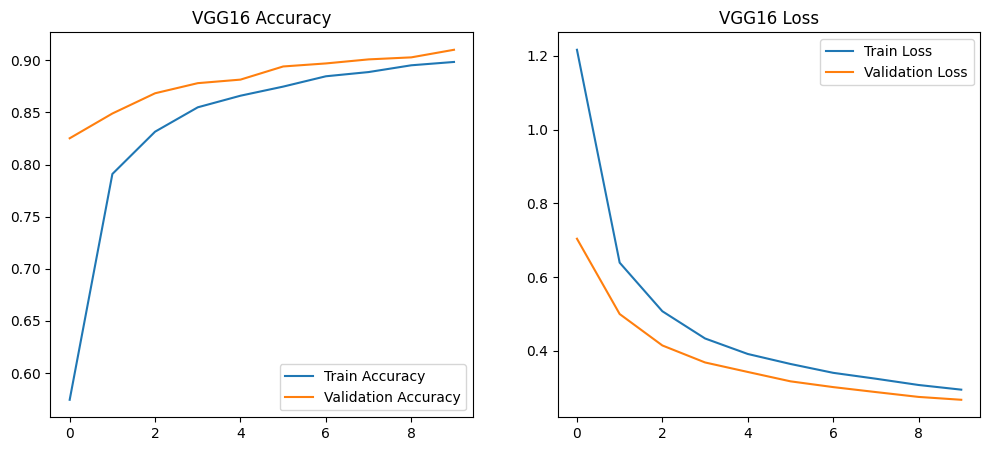

65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step

Classification Report for VGG16
                           precision    recall  f1-score   support

         Corn Common rust       0.96      0.97      0.97       333
      Corn Gray leaf spot       0.86      0.81      0.83       237
             Corn Healthy       0.96      0.97      0.97       314
Corn Northern Leaf Blight       0.86      0.88      0.87       321
      Potato Early blight       0.91      0.94      0.93       319
           Potato Healthy       0.90      0.89      0.90       219
       Potato Late blight       0.89      0.86      0.87       318

                 accuracy                           0.91      2061
                macro avg       0.91      0.90      0.90      2061
             weighted avg       0.91      0.91      0.91      2061



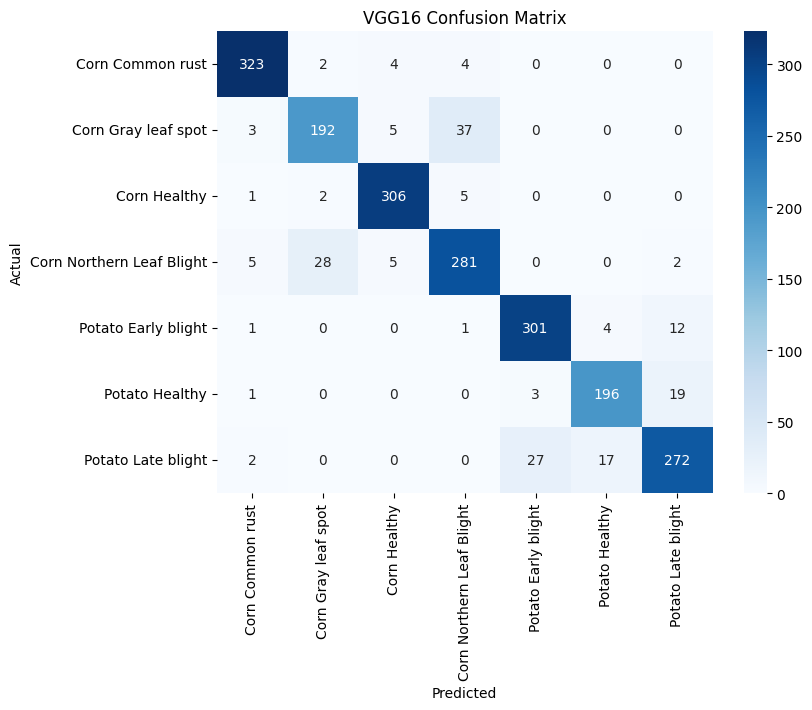

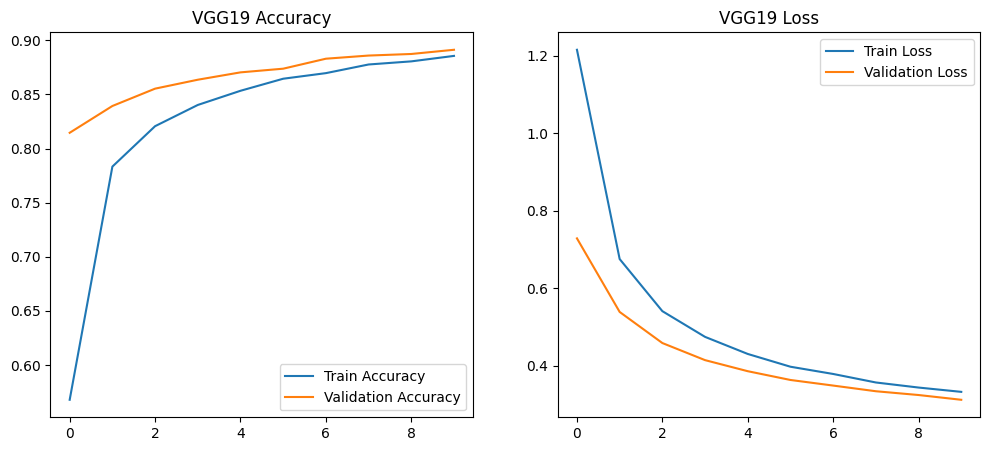

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step

Classification Report for VGG19
                           precision    recall  f1-score   support

         Corn Common rust       0.96      0.95      0.96       333
      Corn Gray leaf spot       0.86      0.72      0.78       237
             Corn Healthy       0.92      0.97      0.94       314
Corn Northern Leaf Blight       0.81      0.87      0.84       321
      Potato Early blight       0.91      0.93      0.92       319
           Potato Healthy       0.89      0.87      0.88       219
       Potato Late blight       0.88      0.87      0.88       318

                 accuracy                           0.89      2061
                macro avg       0.89      0.88      0.89      2061
             weighted avg       0.89      0.89      0.89      2061



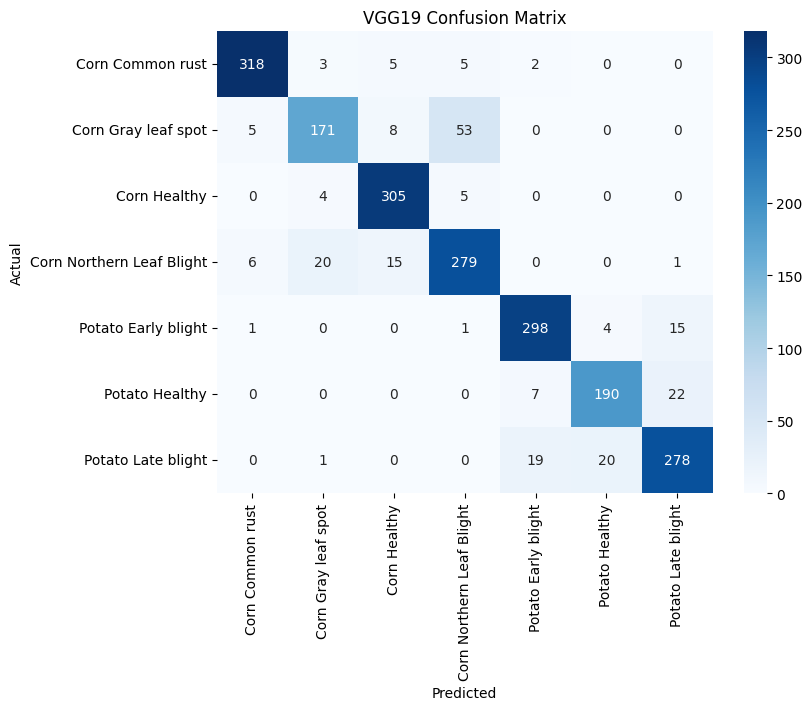

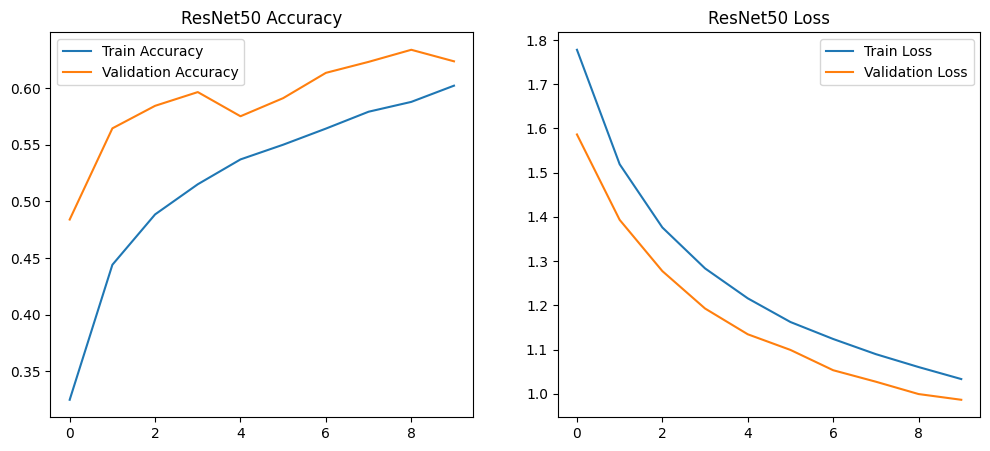

65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step

Classification Report for ResNet50
                           precision    recall  f1-score   support

         Corn Common rust       0.85      0.95      0.90       333
      Corn Gray leaf spot       0.70      0.27      0.39       237
             Corn Healthy       0.81      0.31      0.44       314
Corn Northern Leaf Blight       0.45      0.88      0.59       321
      Potato Early blight       0.75      0.82      0.78       319
           Potato Healthy       0.75      0.23      0.35       219
       Potato Late blight       0.52      0.72      0.61       318

                 accuracy                           0.63      2061
                macro avg       0.69      0.60      0.58      2061
             weighted avg       0.69      0.63      0.60      2061



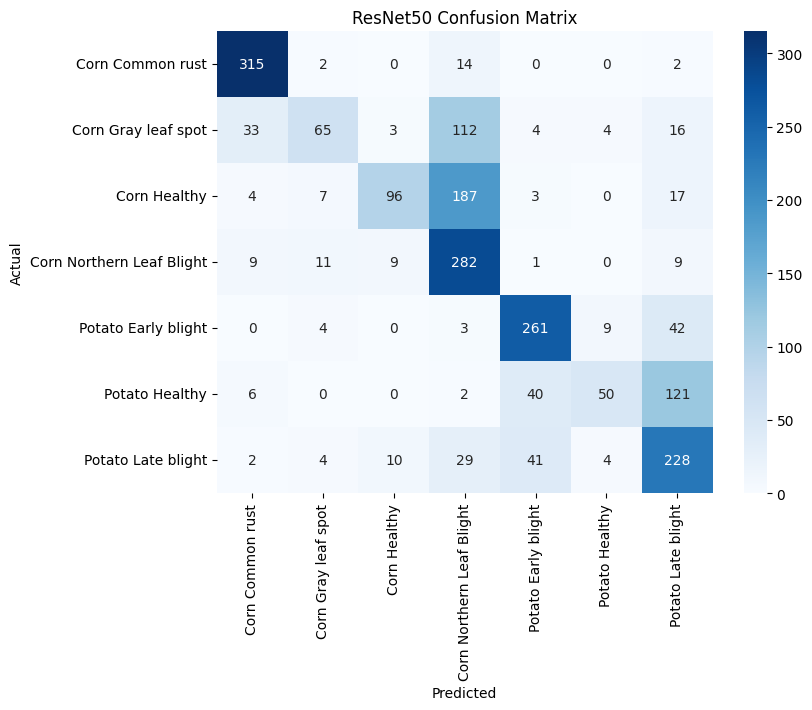

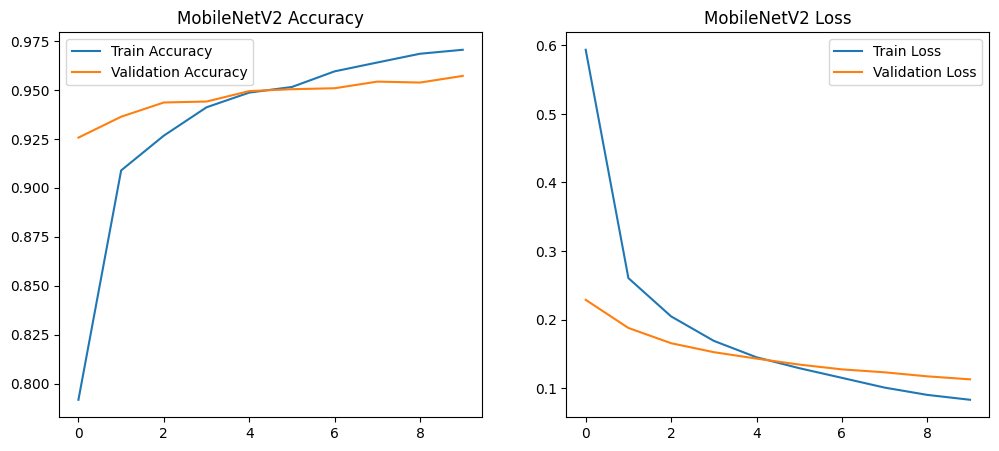

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step

Classification Report for MobileNetV2
                           precision    recall  f1-score   support

         Corn Common rust       0.98      0.98      0.98       333
      Corn Gray leaf spot       0.92      0.89      0.90       237
             Corn Healthy       0.99      1.00      0.99       314
Corn Northern Leaf Blight       0.91      0.93      0.92       321
      Potato Early blight       0.98      0.96      0.97       319
           Potato Healthy       0.98      0.98      0.98       219
       Potato Late blight       0.96      0.97      0.97       318

                 accuracy                           0.96      2061
                macro avg       0.96      0.96      0.96      2061
             weighted avg       0.96      0.96      0.96      2061



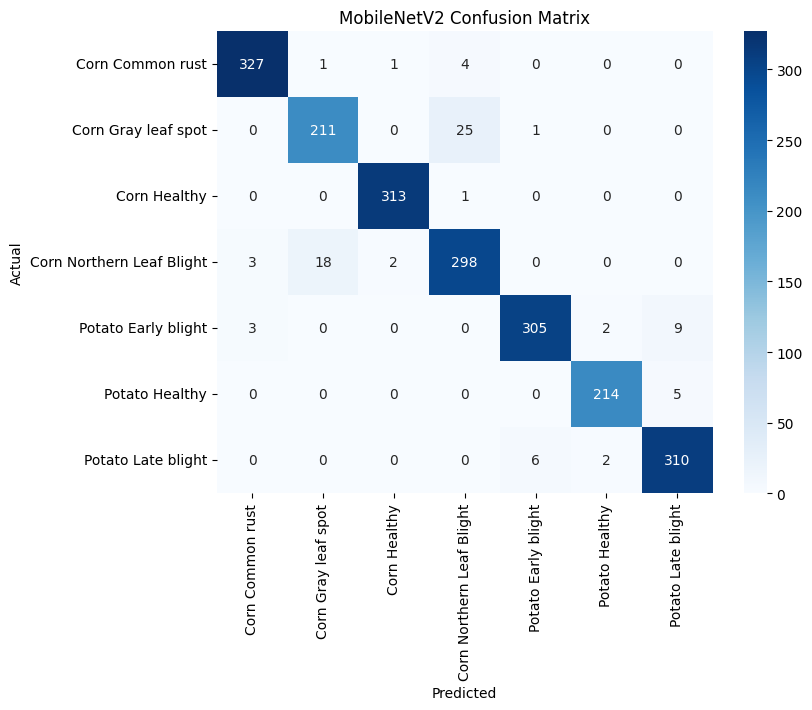

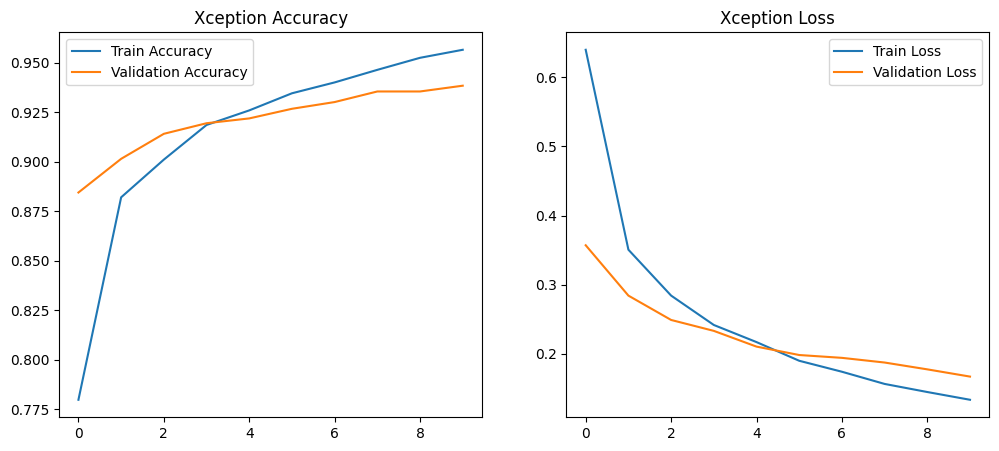

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step

Classification Report for Xception
                           precision    recall  f1-score   support

         Corn Common rust       0.97      0.99      0.98       333
      Corn Gray leaf spot       0.89      0.85      0.87       237
             Corn Healthy       0.97      1.00      0.98       314
Corn Northern Leaf Blight       0.89      0.88      0.88       321
      Potato Early blight       0.96      0.95      0.95       319
           Potato Healthy       0.96      0.97      0.97       219
       Potato Late blight       0.95      0.94      0.94       318

                 accuracy                           0.94      2061
                macro avg       0.94      0.94      0.94      2061
             weighted avg       0.94      0.94      0.94      2061



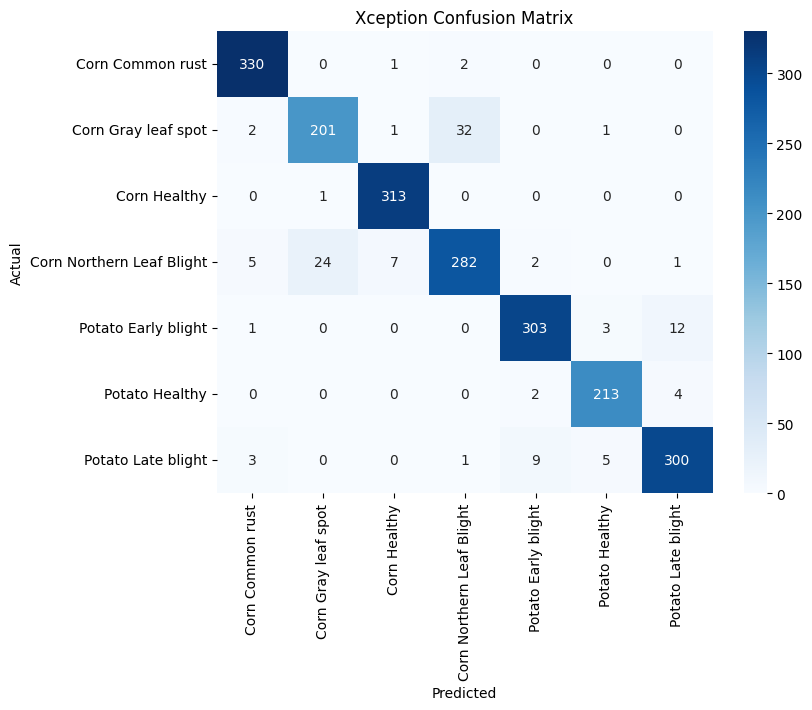

In [27]:
for model_name, (model, history) in history_dict.items():
    plot_metrics(history, model_name)
    evaluate_model(model, test_gen, model_name)
    

In [67]:
import tensorflow as tf
import numpy as np

def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(100, 100))  
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  
    return tf.convert_to_tensor(img, dtype=tf.float32)  


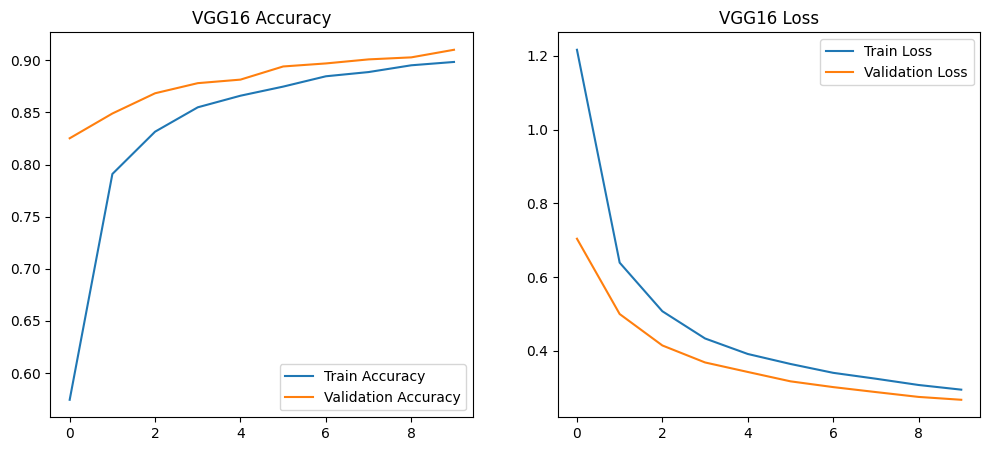

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step

Classification Report for VGG16
                           precision    recall  f1-score   support

         Corn Common rust       0.96      0.97      0.97       333
      Corn Gray leaf spot       0.86      0.81      0.83       237
             Corn Healthy       0.96      0.97      0.97       314
Corn Northern Leaf Blight       0.86      0.88      0.87       321
      Potato Early blight       0.91      0.94      0.93       319
           Potato Healthy       0.90      0.89      0.90       219
       Potato Late blight       0.89      0.86      0.87       318

                 accuracy                           0.91      2061
                macro avg       0.91      0.90      0.90      2061
             weighted avg       0.91      0.91      0.91      2061



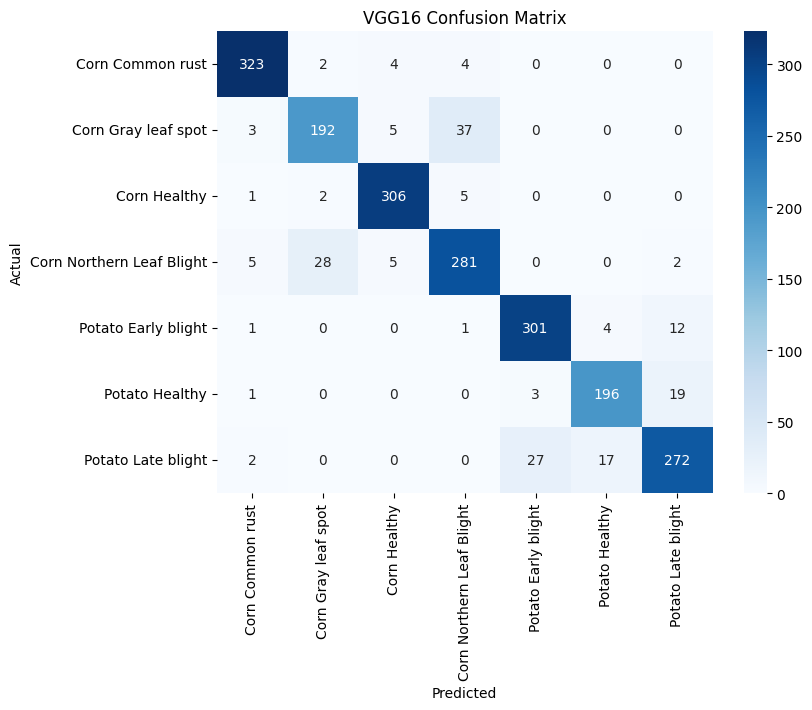

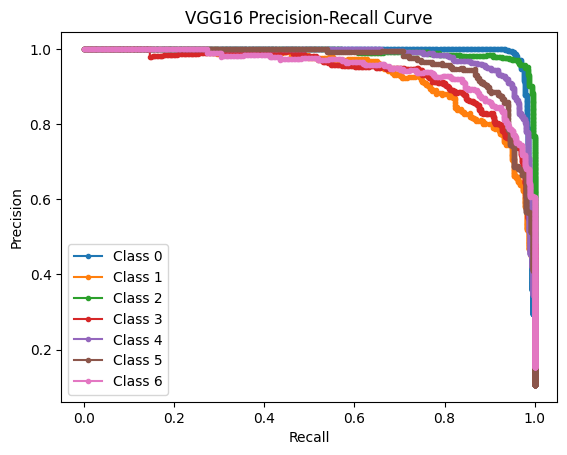

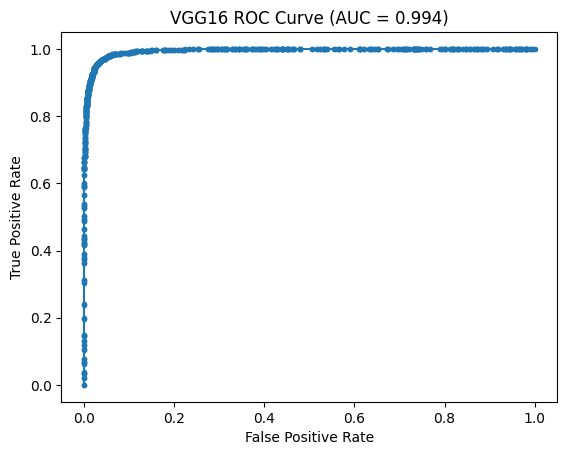

VGG16 AUC Score: 0.993
VGG16 F1 Score: 0.907


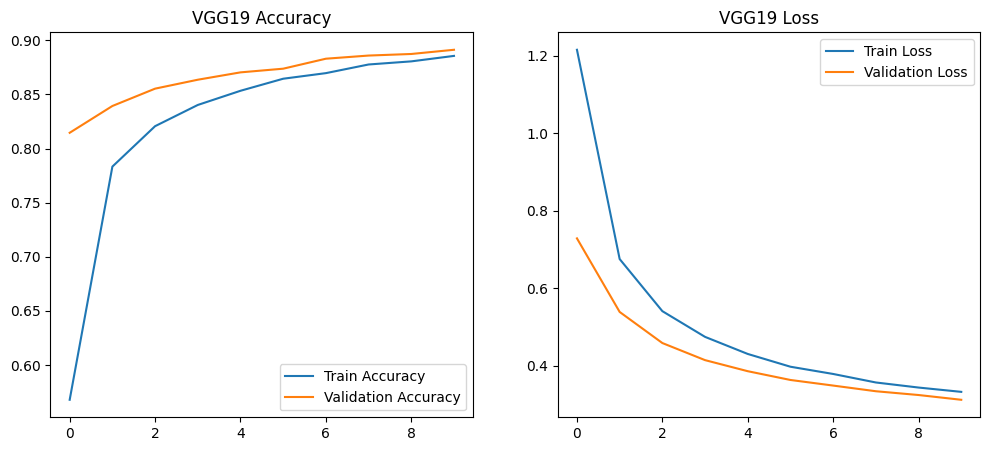

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step

Classification Report for VGG19
                           precision    recall  f1-score   support

         Corn Common rust       0.96      0.95      0.96       333
      Corn Gray leaf spot       0.86      0.72      0.78       237
             Corn Healthy       0.92      0.97      0.94       314
Corn Northern Leaf Blight       0.81      0.87      0.84       321
      Potato Early blight       0.91      0.93      0.92       319
           Potato Healthy       0.89      0.87      0.88       219
       Potato Late blight       0.88      0.87      0.88       318

                 accuracy                           0.89      2061
                macro avg       0.89      0.88      0.89      2061
             weighted avg       0.89      0.89      0.89      2061



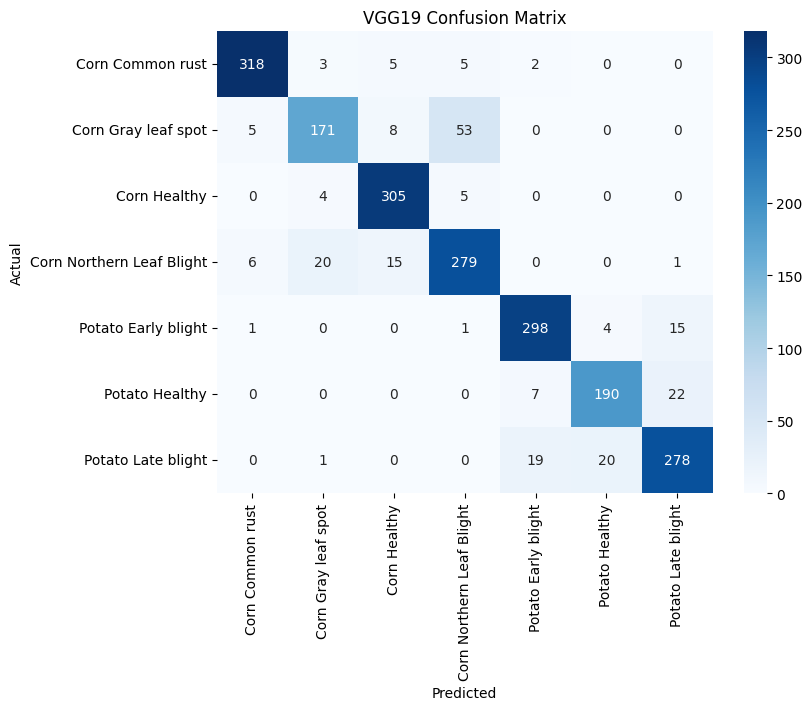

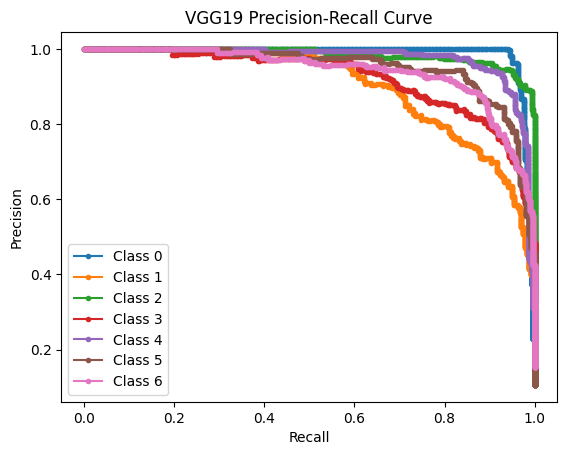

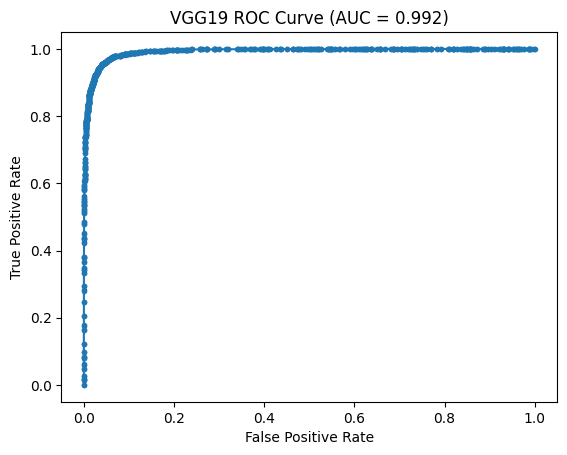

VGG19 AUC Score: 0.991
VGG19 F1 Score: 0.891


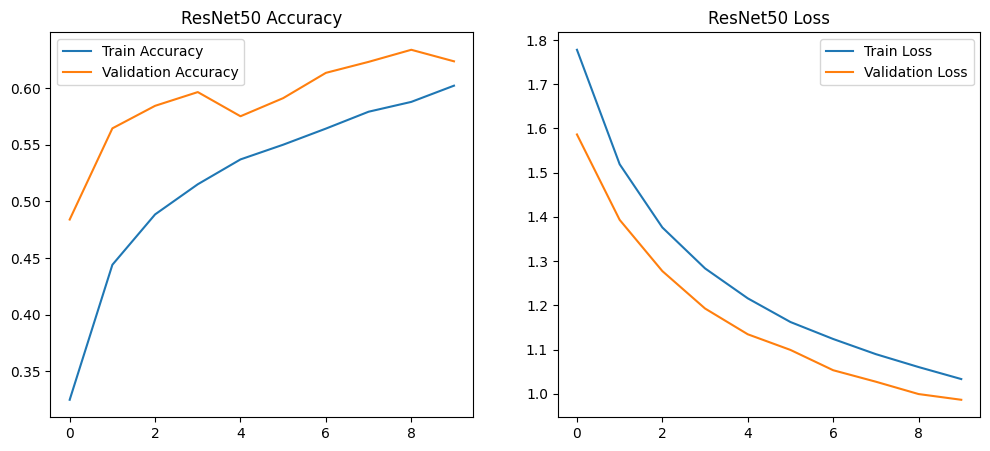

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step

Classification Report for ResNet50
                           precision    recall  f1-score   support

         Corn Common rust       0.85      0.95      0.90       333
      Corn Gray leaf spot       0.70      0.27      0.39       237
             Corn Healthy       0.81      0.31      0.44       314
Corn Northern Leaf Blight       0.45      0.88      0.59       321
      Potato Early blight       0.75      0.82      0.78       319
           Potato Healthy       0.75      0.23      0.35       219
       Potato Late blight       0.52      0.72      0.61       318

                 accuracy                           0.63      2061
                macro avg       0.69      0.60      0.58      2061
             weighted avg       0.69      0.63      0.60      2061



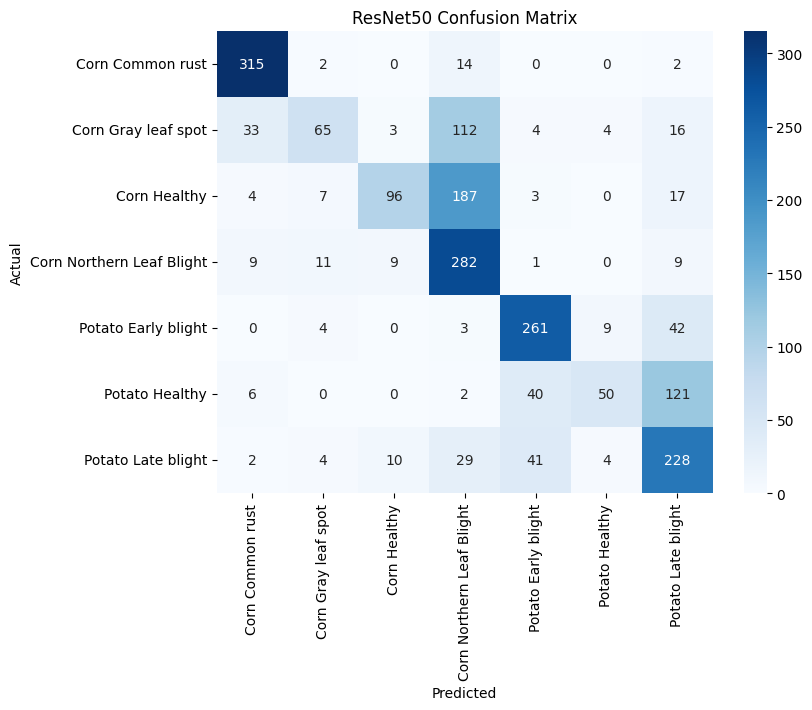

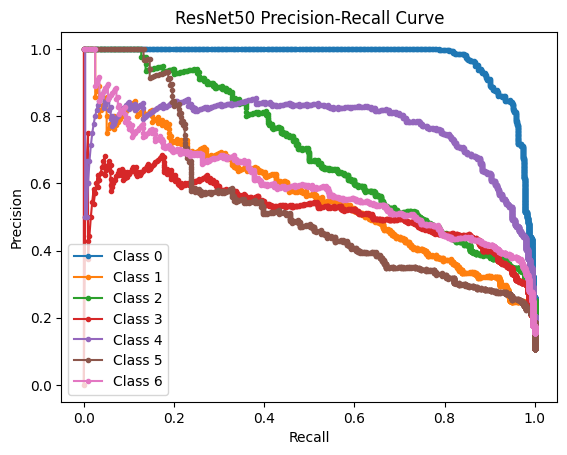

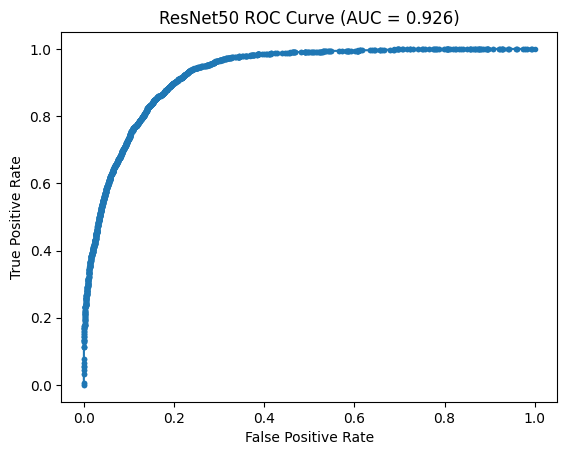

ResNet50 AUC Score: 0.921
ResNet50 F1 Score: 0.602


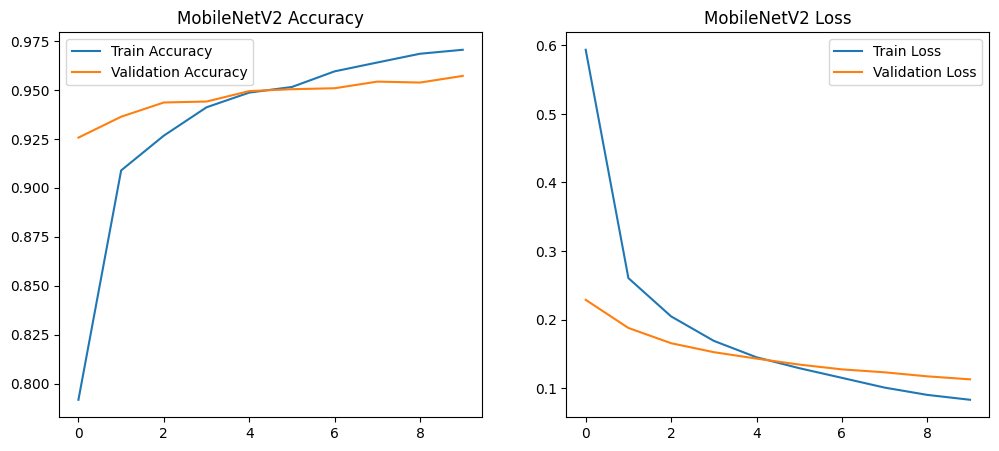

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step

Classification Report for MobileNetV2
                           precision    recall  f1-score   support

         Corn Common rust       0.98      0.98      0.98       333
      Corn Gray leaf spot       0.92      0.89      0.90       237
             Corn Healthy       0.99      1.00      0.99       314
Corn Northern Leaf Blight       0.91      0.93      0.92       321
      Potato Early blight       0.98      0.96      0.97       319
           Potato Healthy       0.98      0.98      0.98       219
       Potato Late blight       0.96      0.97      0.97       318

                 accuracy                           0.96      2061
                macro avg       0.96      0.96      0.96      2061
             weighted avg       0.96      0.96      0.96      2061



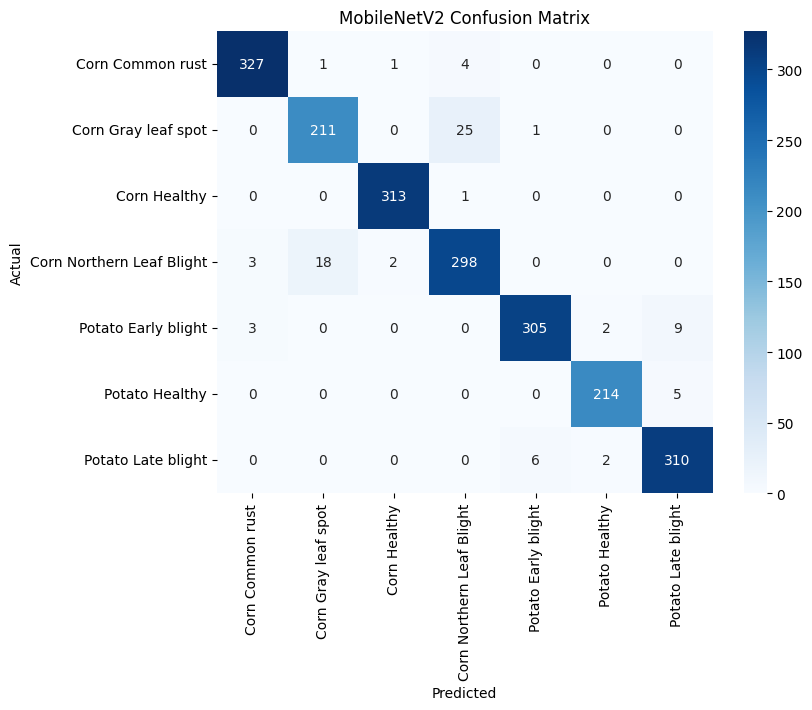

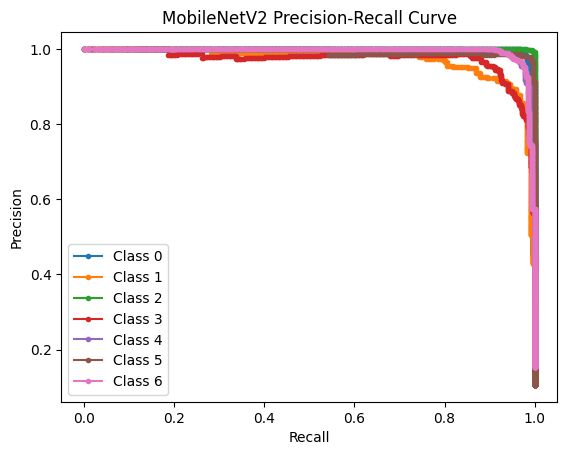

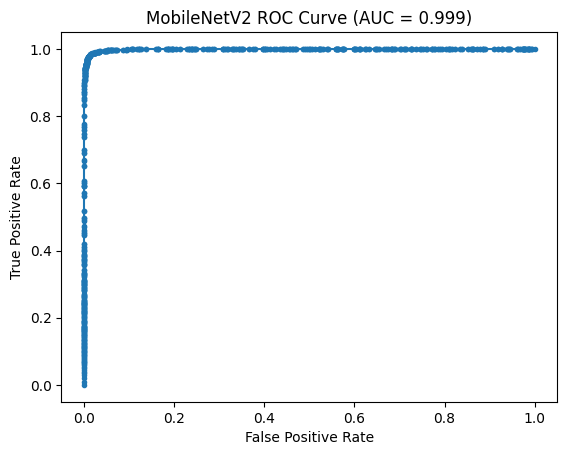

MobileNetV2 AUC Score: 0.998
MobileNetV2 F1 Score: 0.960


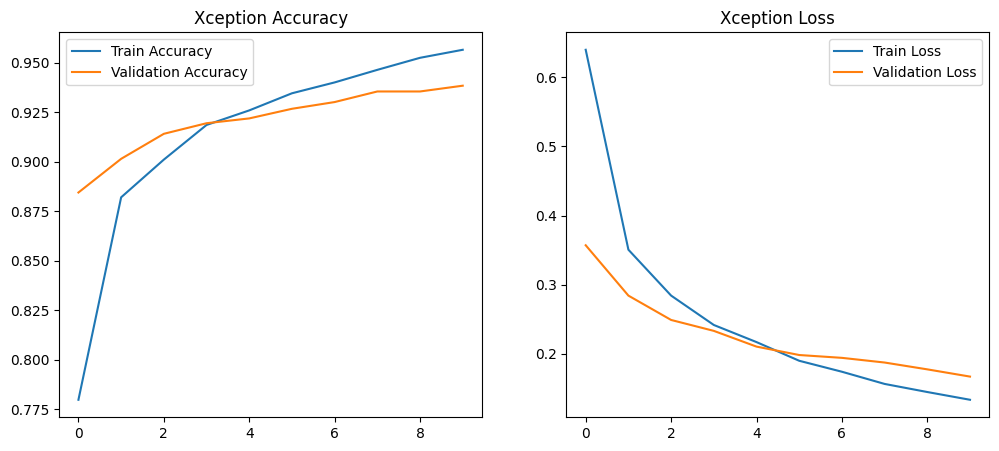

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step

Classification Report for Xception
                           precision    recall  f1-score   support

         Corn Common rust       0.97      0.99      0.98       333
      Corn Gray leaf spot       0.89      0.85      0.87       237
             Corn Healthy       0.97      1.00      0.98       314
Corn Northern Leaf Blight       0.89      0.88      0.88       321
      Potato Early blight       0.96      0.95      0.95       319
           Potato Healthy       0.96      0.97      0.97       219
       Potato Late blight       0.95      0.94      0.94       318

                 accuracy                           0.94      2061
                macro avg       0.94      0.94      0.94      2061
             weighted avg       0.94      0.94      0.94      2061



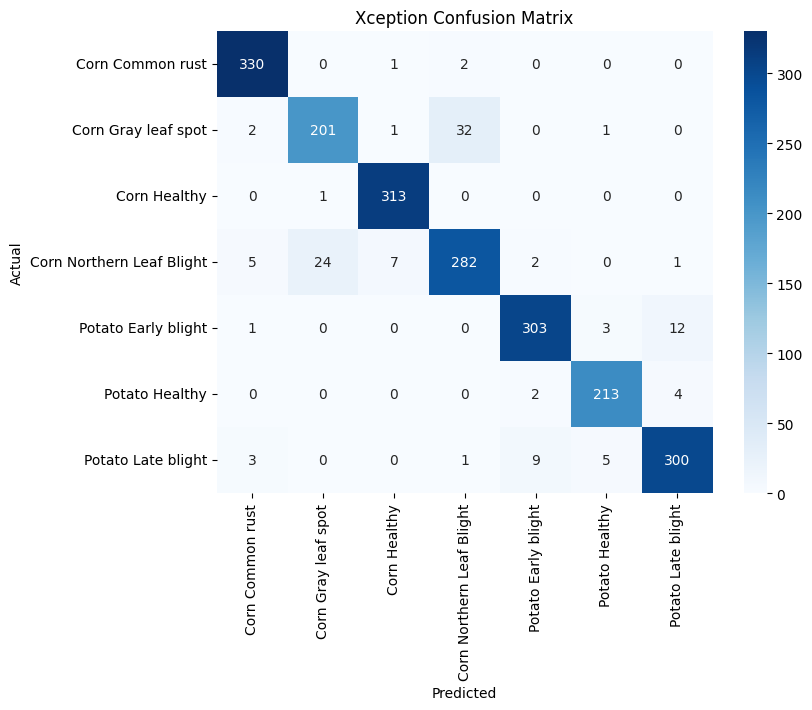

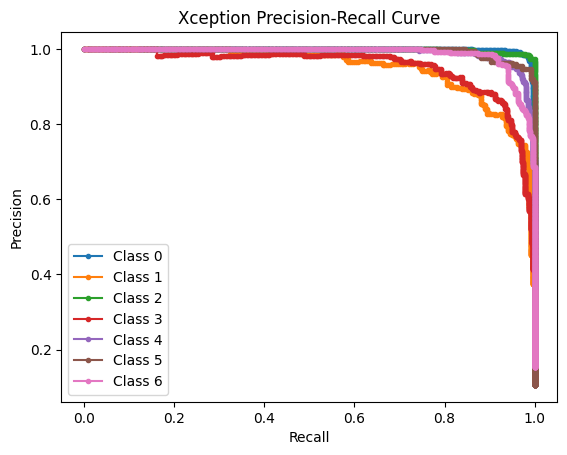

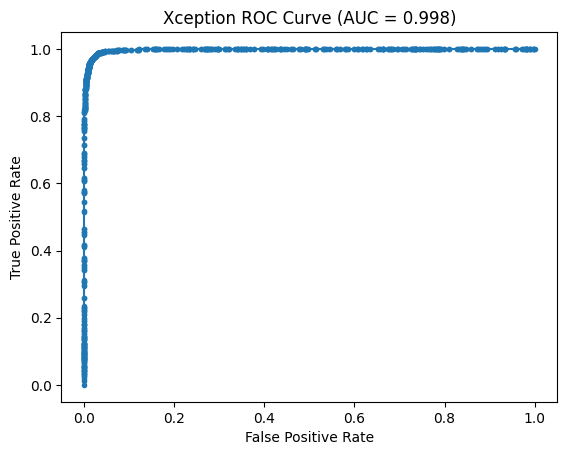

Xception AUC Score: 0.997
Xception F1 Score: 0.942


In [69]:
for model_name, (model, history) in history_dict.items():
    plot_metrics(history, model_name)
    evaluate_model(model, test_gen, model_name)
    
